

### **Домашнее задание**
В этом задании вам предстоит обучить свой собственный классификатор биологического гендера человека по аудиозаписи (спектрограмме). На [семинаре](https://vk.cc/atRKR8) 9 мая мы разобрали, как построить спектрограмму и подать ее в нейросеть, а также написали бейзлайн решение на Keras. 

### Задание 1 (20% баллов)
Взяв данные с семинара из датасета TIMIT (библиотека для работы с ним и подготовки данных также есть в семинаре) натренировать сетку так, чтобы на тестовой выборке accuracy_score был больше 0.97. Возможные исследования: conv1d vs conv2d, batch norm, предобученные сетки из `Imagenet`. Обязательно напишите, что вы использовали и какой вывод. Писать можно на любом фреймворке. 
### Задание 2 (30% баллов)
Подумайте, как бы можно было "испортить" данные для тестовой выборки и впоследствии попробовать восстановить скор при помощи аугментаций трейнсета и усложнения архитектуры? Используя данные из `TEST` усложните выборку и посмотрите, как упадет accuracy_score. Следите, чтобы он не падал ниже 70 -- есть риск тогда не обучиться совсем. Вдохновиться аудио аугментациями можно например [здесь](https://vk.cc/atRLgR). Почитать про то, как еще аугментируют данные, но уже на уровне спектрограмм можно [в блоге Google AI](https://vk.cc/9jCCnk). Посмотрите, какие аугментации влияют сильнее всего? На этом этапе мы пока ничего не учим, а только пытаемся испортить скор бейзлайна с семинара.
### Задание 3 (40% баллов)
При помощи изложенных в предыдущем пункте средств, а также идей и хинтов с семинара, постарайтесь улучшить скор модели на "испорченных" данных. Можно делать все, кроме обучения на тесте :). 
### Задание 4 (10% баллов)
Напишите вывод -- если попробовали какие-то архитектуры, аугментации, но это не помогло, тоже обязательно напишите. Расскажите, что пробовали, и что оказалось самым боевым. Здесь будет релевантно сделать таблицу.

Дополнительные материалы и ссылки:
1. [Текстом про то, как делается преобразование в мел-спектрограмму](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)
2. [Соревнование по классификации голосовых команд](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)
3. [Данные для распознавания речи на русском языке](https://github.com/snakers4/open_stt)
4. [Проект по генерации музыки](https://openai.com/blog/jukebox/)
5. [Опенсорс-проект по разделению песни на минус и вокал](https://github.com/deezer/spleeter)
6. [wav2vec](https://arxiv.org/abs/1904.05862)
7. [Лекция 
Microsoft Research
 про историю Automatic Speech Recognition](https://www.youtube.com/watch?v=q67z7PTGRi8)
8. [Transformer для генерации музыки](https://openai.com/blog/musenet/)
9. [Библиотека, содержащая в себе api для распознавания речи (Google, Microsoft, ...)](https://pypi.org/project/SpeechRecognition/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timit_utils
import librosa
import librosa.display
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from IPython import display

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.grid'] = False

e:\program files win2\python36\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## 0. Preparing Dataset

In [2]:
DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'

In [3]:
corpus = timit_utils.Corpus(DATA_PATH)
sr = 16000

**Переведем сигнал в спектрограмму сразу для всего датасета и сохраним, чтобы не пересчитывать каждый раз:**

Используются параметры: `n_fft=1024`, `hop_length=512`, `power=0.5`

In [12]:
def precompute_mel_spectrogams(corpus, n_fft=1024, hop_length=512, power=0.5, **kwargs):
    sr = 16000
    train_data = []
    test_data = []
    
    for subcorpus, dataset in [(corpus.train, train_data), (corpus.test, test_data)]:
        for name, person in tqdm(subcorpus.people.items(), leave=False):
            for sentence in person.sentences.values():
                wave = sentence.raw_audio
                # normalize wav: wav/max(abs(wav))
                mel_spectrogam = librosa.feature.melspectrogram(wave, sr=sr, n_fft=n_fft, hop_length=hop_length, power=power, **kwargs)
                # normalize spec
                gender = 0 if person.gender == 'F' else 1
                dataset.append((mel_spectrogam, gender))
    
    return train_data, test_data

In [6]:
train_data, test_data = precompute_mel_spectrogams(corpus, 1024, 512, 0.5)

In [7]:
torch.save((train_data, test_data), 'train_test_melspectrogram_1024nfft_512hop_05power.pkl')

In [4]:
# load precomputed specs
train_data, test_data = torch.load('train_test_melspectrogram_1024nfft_512hop_05power.pkl')

**Посмотрим на спектрограмму:**

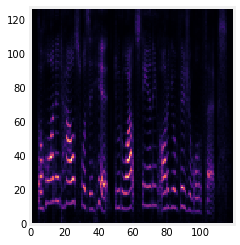

In [32]:
spec = train_data[55][0]
plt.imshow(spec)

**Для удобства сделаем функцию для обращения к датасету по индексу (пригодится в будущем):**

In [5]:
def get_data_at_idx(subcorpus, idx):
    """convenience for retrieving data by index. returns tuple(idx, wave, gender, words, person_name)"""
    i = 0
    for name, person in subcorpus.people.items():
        for sentence in person.sentences.values():
            if idx == i:
                wave = sentence.raw_audio
                words = sentence.words_fullfreq.names
                gender = person.gender
                return i, wave, gender, words, name
            i+=1

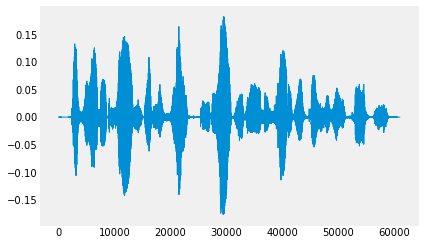

In [27]:
wave = get_data_at_idx(corpus.train, 55)[1]
plt.plot(wave)

**Далее делаются торчевые Dataset, батчевалка и DataLoader.**

AudioDataset поддерживает аугментации, которые будут нужны далее.

Батчевалка либо добивает паддингом, либо обрубает спектрограммы, чтобы они все были длинной 150.

In [6]:
class AudioDataset(Dataset):
    def __init__(self, data, augmentations=None):
        self.inputs, self.labels = zip(*data)
        self.data = data
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.augmentations:
            x = self.augmentations(x)
        return x, 0. if y == 'F' else 1.

In [7]:
def collate_fn(batch):
    # shape: (freq, time)
    inputs = []
    labels = []
    max_len = max([x.shape[1] for x, y in batch])
    max_len = min(max_len, 150)
    
    for x, y in batch:
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        pad_len = max_len - x.shape[1]
        x = F.pad(x, (0, pad_len))
        
        inputs.append(x)
        labels.append(y)
    
    return torch.stack(inputs), torch.stack(labels)

In [29]:
train_dataset = AudioDataset(train_data)
test_dataset = AudioDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

---

## 1. Train on Clean Data

**Для начала создадим простейшую baseline модельку: SimplestCNN_1d**

In [40]:
class SimplestCNN_1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv1d(128, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 32, 5),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(32, 1, 1),
        )
    
    def forward(self, x):
        x = self.stack(x)
        return x
    
SimplestCNN_1d()

SimplestCNN_1d(
  (stack): Sequential(
    (0): Conv1d(128, 64, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
  )
)

**Здест я возьму свой красивый Train цикл с чекпоинтами и другими улучшениями:**

In [8]:
from pathlib import Path
import os
from time import time
import pandas as pd

def train(model, opt, loss_fn, epochs, train_loader, val_loader, scheduler=None, model_name=None, best_loss=None,
          device=None):
    if not device:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # for checkpoints
    if model_name is None:
        model_name = model.__class__.__name__
    path = Path(f'saved_models/{model_name}')
    if not os.path.exists(path): os.mkdir(path)
        
    if best_loss is None:
        best_loss = float('inf')

    train_losses = []
    val_losses = []

    start_time = time()
    
    
    for epoch in range(epochs):
        
        # TRAIN
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred.flatten(), y)
            loss.backward()
            opt.step()
            
            if scheduler:
                assert isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)
                scheduler.step()

            train_loss += loss.item() / len(train_loader)


        # VALIDATE
        model.eval()
        val_loss = 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                y_pred = model(x)
            loss = loss_fn(y_pred.flatten(), y)
            val_loss += loss.item() / len(val_loader)
            
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        
        # CHECKPOINT
        for i in path.glob('*last.pt'): os.remove(i)
        torch.save(model.state_dict(), os.path.join(path, f'{model_name}_val_{val_loss:.4f}_train_{train_loss:.4f}_e{epoch+1}_last.pt'))
        if val_loss < best_loss:
            best_loss = val_loss
            for i in path.glob('*best.pt'): os.remove(i)
            torch.save(model.state_dict(), os.path.join(path, f'{model_name}_val_{val_loss:.4f}_train_{train_loss:.4f}_e{epoch+1}_best.pt'))
        
        
        # VERBOSE
        t = int(time() - start_time)
        s, m = t % 60, t//60
        print(f'{epoch+1:>2} / {epochs}: loss = {train_loss:.4f}, val_loss = {val_loss:.4f} ({m:02}:{s:02})')
        
    return pd.DataFrame([train_losses, val_losses], index=['loss','val_loss']).T

**Обучим SimplestCNN_1d:**

In [23]:
model = SimplestCNN_1d().to(device)

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.BCEWithLogitsLoss()

In [88]:
h = train(model, optimizer, loss_fn, 20, train_loader, test_loader)

 1 / 20: loss = 0.0676, val_loss = 0.0774 (00:02)
 2 / 20: loss = 0.0523, val_loss = 0.1258 (00:04)
 3 / 20: loss = 0.0507, val_loss = 0.0974 (00:06)
 4 / 20: loss = 0.0464, val_loss = 0.0658 (00:08)
 5 / 20: loss = 0.0376, val_loss = 0.0951 (00:10)
 6 / 20: loss = 0.0380, val_loss = 0.0752 (00:12)
 7 / 20: loss = 0.0332, val_loss = 0.0892 (00:15)
 8 / 20: loss = 0.0429, val_loss = 0.1115 (00:17)
 9 / 20: loss = 0.0565, val_loss = 0.0968 (00:19)
10 / 20: loss = 0.0356, val_loss = 0.1069 (00:21)
11 / 20: loss = 0.0337, val_loss = 0.1066 (00:23)
12 / 20: loss = 0.0359, val_loss = 0.0610 (00:25)
13 / 20: loss = 0.0268, val_loss = 0.0725 (00:27)


KeyboardInterrupt: 

**Посмотрим качество на тесте:**

In [9]:
def predict_loader(model, loader):
    model.eval()
    preds = []
    labels = []
    for x, y_true in loader:
        x = x.to(device)
        with torch.no_grad():
            y_pred = model(x).flatten()
        y_pred = (torch.sigmoid(y_pred) > 0.5).float()
        preds.append(y_pred.cpu())
        labels.append(y_true.cpu())
            
    return torch.cat(preds), torch.cat(labels)

In [26]:
preds, labels = predict_loader(model, test_loader)
accuracy_score(labels, preds)

0.9857142857142858

**Модель, хоть и простая, но её уже достаточно для определения гендера по голосу на чистых данных.**

---

## 2. Augmentations

**Далее идет самописный код для разных эксперементов над тем, как можно испортить данные. Здесь я эксперементировал только над спектрограммами. По моим наблюдениям, спектрограмму можно портить почти теми же способами, что и сигнал. Только pitch-shift сделать довольно сложно, т.к. здесь нельзя просто сдвинуть всю спектрограмму вверх/вниз из-за мел шкалы частот**

Как я испортил данные:
1. noise
2. reverse (в задаче с гендером, так можно делать, т.к. нам не важен смысл фраз, важен только голос)
3. time stretch (растягивание/сжатие по времени)
4. time shift (сдвиг влево/вправо)
5. erasing (закрытие спектрограммы вертикальными и горизонтальными полосами)

In [10]:
from numpy.random import rand, uniform, randint
from random import choice
import cv2

class SpecAugmentations:
    def __init__(self):

        self.stretch_prob   = 0.5
        self.reverse_prob   = 0.5
        self.timeshift_prob = 0.8
        self.erasing_prob   = 1.
        self.noise_prob     = 0.8
        
        self.stretch_min = 0.5
        self.stretch_max = 1.5
        self.timeshift_max_shift = 0.5
        self.erasing_window_len = 0.1
        self.erasing_n_max = 3
        self.erasing_window_types = ['boxcar', 'triang', 'hann']
        self.noise_max_amplitude = 0.05
    
    
    def __call__(self, spectrogram):
        # 1. time stretch (resizeX)
        # 2. reverse
        # 3. time shift (here it will be np.roll without masking)
        # 4. erasing (vertical and horizontal masking)
        # 5. noise
        
        x = spectrogram.copy()

        if rand() < self.stretch_prob:
            scale = uniform(self.stretch_min, self.stretch_max)
            x = cv2.resize(spectrogram, (int(x.shape[1]*scale), x.shape[0]))
        
        if rand() < self.reverse_prob:
            x = np.flip(x, 1)
            x = np.roll(x, 0, axis=1)  # normilize ndarray.strides (negative strides problem)

        if rand() < self.timeshift_prob:
            smax = self.timeshift_max_shift
            shift = int(uniform(-smax, smax) * x.shape[1])
            x = np.roll(x, shift, axis=1)
#             sl = slice(None, shift) if shift >= 0 else slice(shift, None)
#             x[:, sl] = 0.
        
        if rand() < self.erasing_prob:
            window_type = choice(self.erasing_window_types)
            
            # verical masking
            n = randint(0, self.erasing_n_max + 1)
            for i in range(n):
                win_len = int(uniform(0.5, 2.) * self.erasing_window_len * x.shape[1])
                window = 1-librosa.filters.get_window(window_type, win_len)
                pos = randint(0, x.shape[1] - win_len)
                x[:, pos:pos+win_len] *= window
            
            # horizontal masking
            n = randint(0, self.erasing_n_max + 1)
            for i in range(n):
                win_len = int(uniform(0.5, 1.5) * self.erasing_window_len * x.shape[0])
                window = 1-librosa.filters.get_window(window_type, win_len)
                pos = randint(0, x.shape[0] - win_len)
                x[pos:pos+win_len] *= window[:, None]

        if rand() < self.noise_prob:
            noise_amplitude = uniform(0., self.noise_max_amplitude)
            x += uniform(size=x.shape)*noise_amplitude
        
        return x

**Сделаем тестовый испорченный датасет и посмотрим на спектрограмму:**

In [45]:
augmentations = SpecAugmentations()
test_dataset_augmentations = AudioDataset(test_data, augmentations)
test_loader_augmentations = DataLoader(test_dataset_augmentations, batch_size=64, shuffle=False, collate_fn=collate_fn)

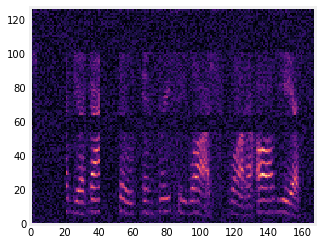

In [52]:
spec = test_dataset_augmentations[10][0]
plt.imshow(spec)

**А что скажет только что обученная модель?**

In [33]:
preds, labels = predict_loader(model, test_loader_augmentations)
accuracy_score(labels, preds)

0.8678571428571429

**Скор, как и ожидалось, упал.**

**И для прикола я хочу послушать как мы испортили голоса бедных людей)**

**Нам поможет алгоритм Гриффина-Лима, который делает inverse stft, восстанавливая сигнал по параметрам изначального stft. В либросе, как оказалось, уже есть удобная готовая функция:**

In [55]:
wave_reconstructed = librosa.feature.inverse.mel_to_audio(spec, sr, n_fft=1024, hop_length=512, power=0.5)

**Послушаем испорченную спектрограмму (ОСТОРОЖНО, СКРИМЕРЫ!!!)**

In [56]:
display.Audio(wave_reconstructed, rate=sr)

**Звучит довольно стремно, можно сойти с ума от долгого прослушивания)**

---

## 3. Train on Spoiled data

In [11]:
augmentations = SpecAugmentations()

train_dataset_augmentations = AudioDataset(train_data, augmentations)
test_dataset_augmentations = AudioDataset(test_data, augmentations)

train_loader_augmentations = DataLoader(train_dataset_augmentations, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader_augmentations = DataLoader(test_dataset_augmentations, batch_size=64, shuffle=False, collate_fn=collate_fn)

**Теперь обучим эту модель на плохих данных:**

In [81]:
model = SimplestCNN_1d().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
h = train(model, optimizer, loss_fn, 10, train_loader_augmentations, test_loader, model_name='CNN_1d_spoiled')

 1 / 10: loss = 0.6160, val_loss = 0.6029 (00:03)
 2 / 10: loss = 0.5518, val_loss = 0.5225 (00:07)
 3 / 10: loss = 0.4301, val_loss = 0.3689 (00:11)
 4 / 10: loss = 0.3255, val_loss = 0.2383 (00:15)
 5 / 10: loss = 0.2402, val_loss = 0.1856 (00:19)
 6 / 10: loss = 0.1696, val_loss = 0.1568 (00:23)
 7 / 10: loss = 0.1477, val_loss = 0.1081 (00:26)
 8 / 10: loss = 0.1277, val_loss = 0.1521 (00:30)
 9 / 10: loss = 0.1361, val_loss = 0.1157 (00:34)
10 / 10: loss = 0.1319, val_loss = 0.1124 (00:38)


In [83]:
optimizer.param_groups[0]['lr'] = 1e-4
h = train(model, optimizer, loss_fn, 5, train_loader_augmentations, test_loader, model_name='CNN_1d_spoiled')

 1 / 5: loss = 0.1129, val_loss = 0.1107 (00:03)
 2 / 5: loss = 0.1058, val_loss = 0.1085 (00:07)
 3 / 5: loss = 0.1184, val_loss = 0.1074 (00:11)
 4 / 5: loss = 0.1134, val_loss = 0.1113 (00:15)
 5 / 5: loss = 0.1179, val_loss = 0.1091 (00:19)


**Здесь и далее будут обозночения:**
    
`test clean` - обучение на испорченных данных, а тест на чистых

`test spoiled` - и обучение, и тест испорчены

In [84]:
preds, labels = predict_loader(model, test_loader)
print(f'test clean: {accuracy_score(labels, preds):.4f}')

preds, labels = predict_loader(model, test_loader_augmentations)
print(f'test spoiled: {accuracy_score(labels, preds):.4f}')

test clean: 0.9738
test spoiled: 0.9506


**Пора попробовать что-нибудь посложнее!**

In [85]:
class CNN_2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 32, (3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, (3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, (3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, (3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2)),
            nn.AdaptiveMaxPool2d(1),
            nn.Conv2d(64, 1, (1,1)),
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # add channel's dim - (batch, channels, H, W)
        x = self.layer(x)
        return x

In [86]:
model = CNN_2d().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
h = train(model, optimizer, loss_fn, 8, train_loader_augmentations, test_loader, model_name='CNN_2d_spoiled')

 1 / 10: loss = 0.2079, val_loss = 0.5000 (00:13)
 2 / 10: loss = 0.1118, val_loss = 0.1095 (00:27)
 3 / 10: loss = 0.0844, val_loss = 0.0995 (00:41)
 4 / 10: loss = 0.0928, val_loss = 0.1130 (00:54)
 5 / 10: loss = 0.0744, val_loss = 0.1167 (01:08)
 6 / 10: loss = 0.0734, val_loss = 0.0891 (01:21)
 7 / 10: loss = 0.0691, val_loss = 0.0730 (01:35)
 8 / 10: loss = 0.0719, val_loss = 0.0814 (01:49)
 9 / 10: loss = 0.0659, val_loss = 0.1009 (02:02)


KeyboardInterrupt: 

In [87]:
optimizer.param_groups[0]['lr'] = 1e-4
h = train(model, optimizer, loss_fn, 4, train_loader_augmentations, test_loader, model_name='CNN_2d_spoiled')

 1 / 4: loss = 0.0518, val_loss = 0.0771 (00:13)
 2 / 4: loss = 0.0553, val_loss = 0.0779 (00:27)
 3 / 4: loss = 0.0484, val_loss = 0.0742 (00:40)
 4 / 4: loss = 0.0501, val_loss = 0.0783 (00:54)


In [89]:
preds, labels = predict_loader(model, test_loader)
print(f'test clean: {accuracy_score(labels, preds):.4f}')

preds, labels = predict_loader(model, test_loader_augmentations)
print(f'test spoiled: {accuracy_score(labels, preds):.4f}')

test clean: 0.9768
test spoiled: 0.9708


**И нам удалось восстановить скор даже на испорченных тестовых данных. Ура!**

---

### Resnet18 (pretrained)

**Для интереса, попробуем пофайнтюнить предобученную resnet18.**

Для реализации пришлось сделать то, **что очень опасно, и что делать не стоит никогда** ~~(но если никто не увидит, то можно)~~:

In [195]:
import warnings

def _flatten(x, *a, **kw):
    warnings.warn('Используется не настоящий flatten!')
    return x

torch.flatten = _flatten

**TL;DR**: так я решил проблему, которая не позволяла сделать свой classifier слой, который мне был так нужен.

В коде резнета torch.flatten захардкоден и вызывается сразу после avgpool, что все портит, т.к. мне нужно сначала пройтись сверткой 1х1, а потом уже сделать avgpool. А torch.flatten выпрямлял тензор, из-за чего spatial размерности смешивались с channels.

In [206]:
class Resnet18_Audio(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.resnet = torchvision.models.resnet18(pretrained=pretrained)
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]))
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1,3,1,1).permute(0,2,3,1)
        # без нормализации тоже хорошо обучается. К тому же здесь она не совсем верная,
        # т.к. изначально на вход приходит не картинка, а спектрограмма из иного распределения.
#         x = (x - self.mean) / self.std
        x = x.permute(0,3,1,2)
        features = self.resnet(x)
        out = self.classifier(features)
        return out

In [207]:
model = Resnet18_Audio(pretrained=True).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
h = train(model, optimizer, loss_fn, 4, train_loader_augmentations, test_loader, model_name='resnet18_spoiled')
optimizer.param_groups[0]['lr'] = 1e-5
h = train(model, optimizer, loss_fn, 1, train_loader_augmentations, test_loader, model_name='resnet18_spoiled')

e:\program files win2\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Используется не настоящий flatten!
  after removing the cwd from sys.path.


 1 / 4: loss = 0.1333, val_loss = 0.3934 (00:14)
 2 / 4: loss = 0.0735, val_loss = 0.0600 (00:30)
 3 / 4: loss = 0.0475, val_loss = 0.0457 (00:45)
 4 / 4: loss = 0.0364, val_loss = 0.0467 (01:00)
 1 / 1: loss = 0.0296, val_loss = 0.0458 (00:15)


In [208]:
preds, labels = predict_loader(model, test_loader)
print(f'test clean: {accuracy_score(labels, preds):.4f}')

np.random.seed(0)
random.seed(0)
preds, labels = predict_loader(model, test_loader_augmentations)
print(f'test spoiled: {accuracy_score(labels, preds):.4f}')

e:\program files win2\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Используется не настоящий flatten!
  after removing the cwd from sys.path.


test clean: 0.9905
test spoiled: 0.9845


**Ии вауу, resnet18 показывает отличный скор!!**

---

## 4. Вывод

**Исользованные аугментации:**
- noise
- reverse (в задаче с гендером, так можно делать, т.к. нам не важен смысл фраз, важен только голос)
- time stretch (растягивание/сжатие по времени)
- time shift (сдвиг влево/вправо)
- erasing (закрытие спектрограммы вертикальными и горизонтальными полосами)

**Сравнение моделей:**

`test clean` - обучение на испорченных данных, а тест на чистых

`test spoiled` - и обучение, и тест испорчены

In [230]:
compare_df = pd.DataFrame({'SimplestCNN_1d':[0.9738, 0.9506], 'CNN_2d':[0.9768, 0.9708], 'Resnet18 (pretrained)':[0.9905, 0.9845]}, index=['test clean', 'test spoiled']).T
compare_df

,test clean,test spoiled
SimplestCNN_1d,0.9738,0.9506
CNN_2d,0.9768,0.9708
Resnet18 (pretrained),0.9905,0.9845


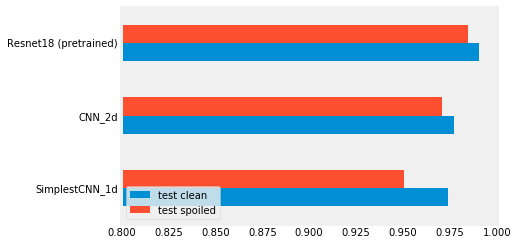

In [231]:
compare_df.plot.barh()
plt.xlim((0.8,1))
plt.legend(loc='lower left')